In [2]:
#Willem Master's Thesis

import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
plt.style.use ("bmh")
import warnings
import numpy as np
import pickle as pkl
import glob
    
from sklearn_extra.cluster import KMedoids

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [3]:
def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters 
    of the operative network.
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
        np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
        n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)
    
    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False
    
    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    links_dc_i = n.links.index[n.links.carrier == 'DC']
    n.links.loc[links_dc_i, 'p_nom'] = \
        n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
    n.links.loc[links_dc_i, 'p_nom_extendable'] = False
    
    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False
    
    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False
    return n

def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)
    
    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0)/network.lines.s_nom)
    max_loading = (network.lines_t.p0/network.lines.s_nom).max(axis = 0)
    print(max_loading)

    #In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    #At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    #it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    #to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)

def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist() 
                                    if network.storage_units.loc[name]["carrier"] == "battery"])
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    network.mremove("Store", [name for name in network.stores.index.tolist()
                             if "BESS" in name])
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                           if "BESS" in name])
    
def add_BESS_loadflexibility(network, network_year, flex_potential = 10000, c_rate = 0.25, flex_share = 0.1):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node. 
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)
    
    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads. 
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization 
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis = 0)
    
    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = network.buses.index.tolist()[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # determin flexibility at bus
        df_loads_bus = df_loads[df_loads["bus"] == bus_name]
        
        ################
        
        
        # TODO: ÄNDERN DER maximalen energie: Die speicherbare energie soll abhängig vom mittelwert der last 
        # über den GESAMTEN zeitraum sein, nicht nur vom mittelwert des aktuellen (1 day) networks!
        
        
        ################
        
        if not df_loads_bus.empty:
            p_flex = df_loads_bus.p_mean * flex_share
        else:
            p_flex = 0
            
        print("p_flex = " + str(p_flex))

        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # add store
        network.add("Store", name = "BESS_{}".format(i),
                    bus = battery_bus,
                    e_nom = p_flex / c_rate,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = p_flex,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
        # discharge link
        network.add("Link",
                    name = "BESS_{}_discharger".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "BESS_{}_charger".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
    network.name = str(network.name) + " BESS loadflexibility"
        
def add_BESS(network):
    '''
    Adds static battery storages (fixed capacity) to the base network
    Removes previously added batteries (links and stores) from the network
    
    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # discharge link
        network.add("Link",
                    name = "Battery_{}_dCH".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "Battery_{}_CH".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # add store
        network.add("Store", name = "BESS_{}".format(i),    
                    bus = battery_bus,
                    e_nom = 200,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = 100,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
    network.name = str(network.name) + " BESS"
    
        
def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])


def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)
    
    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["hard coal","lignite","gas","oil","nuclear","OCGT","CCGT"]
    
    for generator in l_generators:
        
        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name = "{}_pos".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = network.generators.loc[generator]["marginal_cost"],
                                   capital_cost = 0,
                                   p_max_pu = (1 - network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = 0,
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            
        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE 
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.
    For faster computation: Assign to first bus of dataset
    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''  
    mode = "default"
    network_dispatch = network.copy()
    
    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses
    
    if mode == "cluster":
        # Cluster buses to 1 cluster & compute center
        np_busmap = df_busmap[["x","y"]].to_numpy()
        k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
        score = k_medoids.fit(np_busmap)
        x_medoid = k_medoids.cluster_centers_[0][0]
        y_medoid = k_medoids.cluster_centers_[0][1]
        # find single medoid bus in dataframe
        market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)].squeeze()
        bus_name = str(market_bus.name) # save bus name, remove brackets & quotemarks
    else:
        #bus_name = str(df_busmap[0].index.values)[2:-2]
        bus_name = df_busmap.iloc[0].name

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    return network_dispatch

def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch = build_redispatch_network(network, network_dispatch)
    # Solve new network
    network_redispatch.lopf(solver_name="gurobi", pyomo = False, 
                 formulation ="kirchhoff")
    return network_redispatch 
    
# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share, flex_store = True):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    # Adding a battery at every node
    if flex_store == True:
        add_BESS_loadflexibility(network_redispatch_bat, network_year, c_rate, flex_share)
    else:
        add_BESS(network_redispatch_bat)
        
    return network_redispatch_bat
    
def solve_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch_bat = build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True,)
    # Solve new network
    network_redispatch_bat.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
    
    return network_redispatch_bat



def concat_network(list_networks, ignore_standard_types = False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating 
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    #create new network out of first network of the list of identical networks 
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------
    override_components, override_component_attrs = n_input._retrieve_overridden_components()
    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                                     override_components=override_components,
                                     override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):
        df = component.df
        #drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)
        import_components_from_dataframe(nw, df, component.name)
    
    # Time dependent components
    # --------------------
    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)   

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):
        component_t = component.list_name + "_t"
        
        for attr, timeseries in component.pnl.items():
            l_component = []
            for network in list_networks:
                #each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t),attr))
            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis = 0)
            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)
    
    #catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw,attr,getattr(n_input,attr))  
    
    # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj 

    return nw

def redispatch_workflow(network, network_optim, scenario = "no bat",  
                        c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    '''
    Function for executing the whole redispatch workflow.
    
    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    dict_obj_d = {}
    dict_obj_rd = {}
    
    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)
    
    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:,"capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        #print(start_hour)
        n_24 = network.copy(snapshots = network.snapshots[start_hour:start_hour+24])
        
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
        
        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate = 0.25, flex_share = 0.1, flex_store = True)
                
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
        
        # Create output list for the daily objective values dispatch & redispatch
        # ---------------
        dict_obj_d[n_dispatch.snapshots[0].day] = n_dispatch.objective
        dict_obj_rd[n_redispatch.snapshots[0].day] = n_redispatch.objective
        
        # For each results list: Create a network out of daily networks for dispatch & redispatch
        # ---------------
        network_dispatch = concat_network(l_networks_dispatch)
        network_redispatch = concat_network(l_networks_redispatch)
           
    
    return network_dispatch, network_redispatch, dict_obj_d, dict_obj_rd
  
    
def solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    """
    import pickle as pkl
    import glob
    
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    for filepath in glob.iglob(folder + '\*.nc'):
        filename = filepath.split('\\')[-1].split(".")[0]
        path_n = filepath
        path_n_optim = folder + "\solved\\" + filename +".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)
        
        # TEST TEST TEST
        # --------------
        nw = n.copy(snapshots = n.snapshots[0:24*7])
        nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*7])
        
        n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                         c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                            c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        
        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"\results"
        n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                              export_standard_types=False, least_significant_digit=None)
        n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                  export_standard_types=False, least_significant_digit=None)
        
        # export lists with obj values
        with open(export_path + r"\dispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_d, f)      
        with open(export_path + r"\redispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_rd, f)
        with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","wb") as f:
            pkl.dump(dict_obj_rd_bat, f)
            
def redispatch_workflow(network, network_optim, scenario = "no bat",  
                        c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    '''
    Function for executing the whole redispatch workflow.
    
    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    dict_obj_d = {}
    dict_obj_rd = {}
    
    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)
    
    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:,"capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        #print(start_hour)
        n_24 = network.copy(snapshots = network.snapshots[start_hour:start_hour+24])
        
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
        
        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate = 0.25, flex_share = 0.1, flex_store = True)
                
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
        
        # Create output list for the daily objective values dispatch & redispatch
        # ---------------
        dict_obj_d[n_dispatch.snapshots[0].day] = n_dispatch.objective
        dict_obj_rd[n_redispatch.snapshots[0].day] = n_redispatch.objective
        
        # For each results list: Create a network out of daily networks for dispatch & redispatch
        # ---------------
        network_dispatch = concat_network(l_networks_dispatch)
        network_redispatch = concat_network(l_networks_redispatch)
           
    
    return network_dispatch, network_redispatch, dict_obj_d, dict_obj_rd
  
    
def solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    Can also be used for a single redispatch network.
    In any case, saves analysis outputs in target directory.
    """
    single_network = True
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    # Solve a single redispatch network
    if single_network == True:
        filename = "elec_s300_50_ec_lcopt_1H"
        path_n = folder + r"\\" + filename + r".nc"
        path_n_optim = folder + r"\solved\\" + filename + r".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)

        # TEST TEST TEST
        # --------------
        nw = n.copy(snapshots = n.snapshots[0:24*31])
        nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*31])

        n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                         c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                            c_rate = 0.25, flex_share = 0.1 ,flex_store = True)

        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"\results"
        n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                              export_standard_types=False, least_significant_digit=None)
        n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                  export_standard_types=False, least_significant_digit=None)

        # export lists with obj values
        with open(export_path + r"\dispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_d, f)      
        with open(export_path + r"\redispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_rd, f)
        with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","wb") as f:
            pkl.dump(dict_obj_rd_bat, f)
    # Solve all redispatch networks from within folder
    else: 
        for filepath in glob.iglob(folder + '\*.nc'):
            filename = filepath.split('\\')[-1].split(".")[0]
            path_n = filepath
            path_n_optim = folder + "\solved\\" + filename +".nc"
            # Define network and network_optim
            n = pypsa.Network(path_n)
            n_optim = pypsa.Network(path_n_optim)

            # TEST TEST TEST
            # --------------
            nw = n.copy(snapshots = n.snapshots[0:24*7])
            nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*7])

            n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                             c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
            n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                                c_rate = 0.25, flex_share = 0.1 ,flex_store = True)

            # export solved dispatch & redispatch workflow as well as objective value list
            export_path = folder + r"\results"
            n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                                 export_standard_types=False, least_significant_digit=None)
            n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                                  export_standard_types=False, least_significant_digit=None)
            n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                      export_standard_types=False, least_significant_digit=None)

            # export lists with obj values
            with open(export_path + r"\dispatch\objective\\" + filename + r".pickle","wb") as f:
                pkl.dump(dict_obj_d, f)      
            with open(export_path + r"\redispatch\objective\\" + filename + r".pickle","wb") as f:
                pkl.dump(dict_obj_rd, f)
            with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","wb") as f:
                pkl.dump(dict_obj_rd_bat, f)

In [6]:
solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True,)

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_un


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-03-29
Using license file C:\gurobi903\gurobi.lic
Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xiis7u2j.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xedf69083
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [1e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8407 columns
Presolve time: 0.04s
Presolved: 1704 rows, 2778 columns, 9930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA

INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.06s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-4hkapvao.lp
Reading time = 0.34 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xeb5edb38
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [1e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43279 rows and 12509 columns
Presolve time: 0.06s
Presolved: 2225 rows, 9068 columns, 17865 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.162e+04
 Factor NZ  : 5.910e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.504e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ntfm33nh.lp
Reading time = 0.22 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xaf01bf6e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8416 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2769 columns, 9921 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-hslgoy_g.lp
Reading time = 0.19 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x0fc13ae6
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43276 rows and 12283 columns
Presolve time: 0.05s
Presolved: 2228 rows, 9294 columns, 18130 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.166e+04
 Factor NZ  : 5.883e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.494e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-o0h_jrb4.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xd0e0c11e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8421 columns
Presolve time: 0.04s
Presolved: 1704 rows, 2764 columns, 9916 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-q4pnmyix.lp
Reading time = 0.23 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x87d95789
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [2e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43275 rows and 12206 columns
Presolve time: 0.05s
Presolved: 2229 rows, 9371 columns, 18232 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.168e+04
 Factor NZ  : 5.894e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.536e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 4.07e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-1_a_akzx.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x3e04f313
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8424 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2761 columns, 9913 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-vo01gzlt.lp
Reading time = 0.20 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x4a67ad3a
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43275 rows and 12313 columns
Presolve time: 0.06s
Presolved: 2229 rows, 9264 columns, 18099 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.167e+04
 Factor NZ  : 5.878e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.494e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 3.17e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-nyzf0id8.lp
Reading time = 0.23 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x39090872
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8420 columns
Presolve time: 0.07s
Presolved: 1704 rows, 2765 columns, 9917 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.69e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.57s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-viay8egd.lp
Reading time = 0.19 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x53355882
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43275 rows and 12226 columns
Presolve time: 0.05s
Presolved: 2229 rows, 9351 columns, 18194 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.167e+04
 Factor NZ  : 5.879e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.492e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-x7hsgyfs.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x31d8b36b
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.13e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-apbsqfno.lp
Reading time = 0.20 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x5afab082
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43278 rows and 12613 columns
Presolve time: 0.06s
Presolved: 2226 rows, 8964 columns, 17759 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.164e+04
 Factor NZ  : 5.894e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.498e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 4.48e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-4ftz7yzl.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xbb53960a
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8425 columns
Presolve time: 0.04s
Presolved: 1704 rows, 2760 columns, 9912 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-3_h0e79w.lp
Reading time = 0.20 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x8082327b
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43282 rows and 12469 columns
Presolve time: 0.06s
Presolved: 2222 rows, 9108 columns, 17892 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.161e+04
 Factor NZ  : 5.907e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.504e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-iqt6tg5m.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xea63c0f9
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.04s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.98e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-fwv8feyp.lp
Reading time = 0.40 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xfca638c1
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43277 rows and 12149 columns
Presolve time: 0.10s
Presolved: 2227 rows, 9428 columns, 18305 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.170e+04
 Factor NZ  : 6.042e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.796e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-o5z0963f.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x2b2d2f3f
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.04s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-v4tbzkky.lp
Reading time = 0.39 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x3cecb74f
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43282 rows and 12163 columns
Presolve time: 0.10s
Presolved: 2222 rows, 9414 columns, 18291 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.170e+04
 Factor NZ  : 6.074e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.824e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 3.42e-05
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-gvp41h1d.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x0f73a082
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8427 columns
Presolve time: 0.04s
Presolved: 1704 rows, 2758 columns, 9910 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.90e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.53s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xm_yuol9.lp
Reading time = 0.19 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xaf14ed35
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43278 rows and 12308 columns
Presolve time: 0.05s
Presolved: 2226 rows, 9269 columns, 18105 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.165e+04
 Factor NZ  : 5.996e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.724e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 2.54e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-rsl2ibir.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xa38b806e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8424 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2761 columns, 9913 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-qqj81_4o.lp
Reading time = 0.37 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xace83ffd
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43283 rows and 12890 columns
Presolve time: 0.09s
Presolved: 2221 rows, 8687 columns, 17532 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.162e+04
 Factor NZ  : 5.944e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.673e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 1.04e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-0hkm3_ey.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xdc0bed29
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8427 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2758 columns, 9910 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.96e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.04s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-rc7xbiag.lp
Reading time = 0.37 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x028c0be0
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43284 rows and 12703 columns
Presolve time: 0.10s
Presolved: 2220 rows, 8874 columns, 17753 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.167e+04
 Factor NZ  : 5.942e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.629e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-i40j_8y4.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x3e44fd70
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.07s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.39e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-0kpgxobq.lp
Reading time = 0.18 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xd559b4c9
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43281 rows and 12349 columns
Presolve time: 0.05s
Presolved: 2223 rows, 9228 columns, 18051 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.164e+04
 Factor NZ  : 5.891e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.519e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 9.44e-05
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-rxhog4iz.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x7d20c3e6
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8424 columns
Presolve time: 0.07s
Presolved: 1704 rows, 2761 columns, 9913 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.16e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-y0337i4d.lp
Reading time = 0.18 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x5ac3a9df
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43280 rows and 12442 columns
Presolve time: 0.05s
Presolved: 2224 rows, 9135 columns, 17907 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.162e+04
 Factor NZ  : 5.900e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.500e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-3n__jcub.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xe3644829
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8423 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2762 columns, 9914 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.20e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-nypevt_v.lp
Reading time = 0.37 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x75bfae59
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43271 rows and 12136 columns
Presolve time: 0.09s
Presolved: 2233 rows, 9441 columns, 18306 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.177e+04
 Factor NZ  : 6.060e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.836e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-y4g0k9i5.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xd99ed781
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [8e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.19e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ki85e_qq.lp
Reading time = 0.19 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xb4ee2bfa
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [8e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43278 rows and 12122 columns
Presolve time: 0.05s
Presolved: 2226 rows, 9455 columns, 18333 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.174e+04
 Factor NZ  : 6.026e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.780e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 5.32e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-cwvumr14.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xbc7e3846
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8427 columns
Presolve time: 0.07s
Presolved: 1704 rows, 2758 columns, 9910 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.24e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ackeu6as.lp
Reading time = 0.18 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x0a241d07
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43266 rows and 12105 columns
Presolve time: 0.05s
Presolved: 2238 rows, 9472 columns, 18340 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.179e+04
 Factor NZ  : 6.107e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.865e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 4.87e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-fazv16iu.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xc20a49fc
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [7e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.16e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ln10wxnj.lp
Reading time = 0.38 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x1f9efd49
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [7e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43269 rows and 12148 columns
Presolve time: 0.08s
Presolved: 2235 rows, 9429 columns, 18296 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.176e+04
 Factor NZ  : 6.105e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.866e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 8.51e-05
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-zf8h8j37.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xa55cc204
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.02s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xj1z59om.lp
Reading time = 0.34 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x1a1c10c9
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43279 rows and 12149 columns
Presolve time: 0.05s
Presolved: 2225 rows, 9428 columns, 18309 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.167e+04
 Factor NZ  : 5.873e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.538e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 5.30e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-icc_d1r5.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xeb26b72b
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.34e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.77s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-lwcsm4gy.lp
Reading time = 0.37 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x04f98f64
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43279 rows and 12379 columns
Presolve time: 0.08s
Presolved: 2225 rows, 9198 columns, 18031 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.165e+04
 Factor NZ  : 5.904e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.546e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-vue3hj0i.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xe28bbfea
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8425 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2760 columns, 9912 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-bi88wfv8.lp
Reading time = 0.37 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x1828fc19
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43280 rows and 12595 columns
Presolve time: 0.08s
Presolved: 2224 rows, 8982 columns, 17752 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.158e+04
 Factor NZ  : 6.031e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.693e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 2.12e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xdedq35t.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x284b17c2
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.49s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-amx4fyxz.lp
Reading time = 0.18 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xdea15a98
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43289 rows and 12211 columns
Presolve time: 0.06s
Presolved: 2215 rows, 9366 columns, 18243 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.167e+04
 Factor NZ  : 5.951e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.661e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 5.38e-05
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ms5262lb.lp
Reading time = 0.13 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xafdfc265
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.08e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.61s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-0vdqxg8u.lp
Reading time = 0.20 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x327dc501
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43282 rows and 12129 columns
Presolve time: 0.06s
Presolved: 2222 rows, 9448 columns, 18331 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.169e+04
 Factor NZ  : 6.070e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.820e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 2.90e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-6ymbfq2q.lp
Reading time = 0.20 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x18d6907f
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.59s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-fqpr_gk6.lp
Reading time = 0.20 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x4f0208b3
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43282 rows and 12152 columns
Presolve time: 0.06s
Presolved: 2222 rows, 9425 columns, 18310 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.170e+04
 Factor NZ  : 6.085e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.884e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-0s_w6ezk.lp
Reading time = 0.22 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x5ce97ce9
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8430 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2755 columns, 9907 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.56s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-73zyhknr.lp
Reading time = 0.37 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x88459d9d
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43285 rows and 12179 columns
Presolve time: 0.09s
Presolved: 2219 rows, 9398 columns, 18255 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.167e+04
 Factor NZ  : 5.901e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.574e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 3.40e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-l4itglb1.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x458a79ff
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8423 columns
Presolve time: 0.04s
Presolved: 1704 rows, 2762 columns, 9914 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-s9dbpkoz.lp
Reading time = 0.40 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xd971c48e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43275 rows and 12561 columns
Presolve time: 0.08s
Presolved: 2229 rows, 9016 columns, 17857 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.169e+04
 Factor NZ  : 6.128e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.925e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 1.99e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-pd5ein8e.lp
Reading time = 0.22 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x1d9d272e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.57s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ls74w3u4.lp
Reading time = 0.20 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x0d132615
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43279 rows and 12679 columns
Presolve time: 0.05s
Presolved: 2225 rows, 8898 columns, 17717 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.166e+04
 Factor NZ  : 5.938e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.598e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: -4.94e-10
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation 

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-stg6fh2p.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x5f4fcc74
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [6e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8425 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2760 columns, 9912 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.15e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.35s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-daj9r6so.lp
Reading time = 0.52 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0xb7782d56
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [6e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43279 rows and 12413 columns
Presolve time: 0.11s
Presolved: 2225 rows, 9164 columns, 17986 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.164e+04
 Factor NZ  : 5.930e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.550e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 4.01e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-kpn3fls8.lp
Reading time = 0.29 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x63de90ff
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.08s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.11e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.57s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ll14uwt2.lp
Reading time = 0.21 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x83bfe158
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43271 rows and 12138 columns
Presolve time: 0.05s
Presolved: 2233 rows, 9439 columns, 18306 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.176e+04
 Factor NZ  : 6.059e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.832e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 4.47e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-e6fc8_cd.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xe5bbd893
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.07e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.62s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-zg61cdwy.lp
Reading time = 0.43 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x8fb639d5
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43290 rows and 12194 columns
Presolve time: 0.10s
Presolved: 2214 rows, 9383 columns, 18259 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.166e+04
 Factor NZ  : 5.947e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.646e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 2.90e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-k8d5i77v.lp
Reading time = 0.22 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x50fa761c
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.15e+07
INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-3575nmt9.lp
Reading time = 0.20 seconds
obj: 45504 rows, 21577 columns, 73512 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 45504 rows, 21577 columns and 73512 nonzeros
Model fingerprint: 0x0096a828
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43274 rows and 12156 columns
Presolve time: 0.06s
Presolved: 2230 rows, 9421 columns, 18297 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.175e+04
 Factor NZ  : 6.079e+04 (roughly 5 MBytes of memory)
 Factor Ops : 2.892e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-_ku5q632.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xedf69083
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [1e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8407 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2778 columns, 9930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 1.75e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.91s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xilq6w49.lp
Reading time = 0.47 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x34940ce4
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [1e-05, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51621 rows and 13634 columns
Presolve time: 0.10s
Presolved: 3483 rows, 12743 columns, 24926 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.429e+04
 Factor NZ  : 2.253e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.651e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 1.50e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-5lj91fb2.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xaf01bf6e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8416 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2769 columns, 9921 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.47e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.91s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-umi_tspd.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x5f0c0f68
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [2e+01, 1e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51621 rows and 13422 columns
Presolve time: 0.05s
Presolved: 3483 rows, 12955 columns, 25145 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.430e+04
 Factor NZ  : 2.185e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.453e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-fct51s7s.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xd0e0c11e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [2e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8421 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2764 columns, 9916 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.81e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.37s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-8pb9u3vm.lp
Reading time = 0.26 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xb0746cac
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [2e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51601 rows and 13317 columns
Presolve time: 0.07s
Presolved: 3503 rows, 13060 columns, 25285 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.436e+04
 Factor NZ  : 2.365e+05 (roughly 9 MBytes of memory)
 Factor Ops : 4.310e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-gr31_q47.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x3e04f313
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8424 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2761 columns, 9913 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.94s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-w9dbhuo4.lp
Reading time = 0.46 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x18aa2b41
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51611 rows and 13443 columns
Presolve time: 0.09s
Presolved: 3493 rows, 12934 columns, 25134 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.432e+04
 Factor NZ  : 2.249e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.706e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-_0s_9pgf.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x39090872
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8420 columns
Presolve time: 0.05s
Presolved: 1704 rows, 2765 columns, 9917 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.69e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.88s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-cffzq53z.lp
Reading time = 0.34 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x3225b1b9
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51616 rows and 13352 columns
Presolve time: 0.09s
Presolved: 3488 rows, 13025 columns, 25224 nonzeros

Ordering time: 0.06s

Barrier statistics:
 AA' NZ     : 1.431e+04
 Factor NZ  : 2.259e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.644e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-1yiq679i.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x31d8b36b
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.13e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.93s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-pmtynt_e.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x66244344
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51628 rows and 13738 columns
Presolve time: 0.05s
Presolved: 3476 rows, 12639 columns, 24864 nonzeros

Ordering time: 0.04s

Barrier statistics:
 AA' NZ     : 1.429e+04
 Factor NZ  : 2.214e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.528e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 3.31e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-yk3imt94.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xbb53960a
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8425 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2760 columns, 9912 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.54s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-5vl2vi2l.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xac0d52ab
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51627 rows and 13604 columns
Presolve time: 0.05s
Presolved: 3477 rows, 12773 columns, 24971 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.429e+04
 Factor NZ  : 2.318e+05 (roughly 8 MBytes of memory)
 Factor Ops : 4.130e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xab51hvg.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xea63c0f9
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.05s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.98e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.83s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-r4c1vplu.lp
Reading time = 0.46 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x52bcc89c
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51596 rows and 13258 columns
Presolve time: 0.09s
Presolved: 3508 rows, 13119 columns, 25352 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.228e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.452e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-wa1f34b1.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x2b2d2f3f
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.13e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.86s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-0kicw_q1.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xf51d9ff2
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51599 rows and 13280 columns
Presolve time: 0.09s
Presolved: 3505 rows, 13097 columns, 25321 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.436e+04
 Factor NZ  : 2.300e+05 (roughly 9 MBytes of memory)
 Factor Ops : 4.050e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-a7w_gxtn.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x0f73a082
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8427 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2758 columns, 9910 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.90e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.87s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-z_0ujftk.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x43fc8fca
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51605 rows and 13430 columns
Presolve time: 0.06s
Presolved: 3499 rows, 12947 columns, 25227 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.142e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.206e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ec_8k1hf.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xa38b806e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8424 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2761 columns, 9913 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.95e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.27s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-5eqcwo5b.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xa3cf560d
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51610 rows and 14002 columns
Presolve time: 0.05s
Presolved: 3494 rows, 12375 columns, 24720 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.435e+04
 Factor NZ  : 2.202e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.288e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-x0muy0vj.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xdc0bed29
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8427 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2758 columns, 9910 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.96e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.85s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-6mnafsyt.lp
Reading time = 0.46 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x4340199c
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51597 rows and 13811 columns
Presolve time: 0.09s
Presolved: 3507 rows, 12566 columns, 24798 nonzeros

Ordering time: 0.06s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.308e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.712e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-qkh_wd1z.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x3e44fd70
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.05s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.39e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-a844e386.lp
Reading time = 0.46 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xa53528ed
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51626 rows and 13478 columns
Presolve time: 0.09s
Presolved: 3478 rows, 12899 columns, 25059 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.427e+04
 Factor NZ  : 2.245e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.489e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-cfj618i1.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x7d20c3e6
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8424 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2761 columns, 9913 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.16e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.88s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-kbhjh495.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x600eb42b
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51634 rows and 13576 columns
Presolve time: 0.05s
Presolved: 3470 rows, 12801 columns, 25029 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.428e+04
 Factor NZ  : 2.404e+05 (roughly 9 MBytes of memory)
 Factor Ops : 4.436e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xrmginar.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xe3644829
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8423 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2762 columns, 9914 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.20e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.93s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-4utq7zon.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x3c6f82e7
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51598 rows and 13253 columns
Presolve time: 0.05s
Presolved: 3506 rows, 13124 columns, 25384 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.438e+04
 Factor NZ  : 2.173e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.270e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-pqpsqojq.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xd99ed781
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [8e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.19e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.87s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-24xm2nxp.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x2596df9f
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [8e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51596 rows and 13240 columns
Presolve time: 0.05s
Presolved: 3508 rows, 13137 columns, 25371 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.198e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.418e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-py4vafsk.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xbc7e3846
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8427 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2758 columns, 9910 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.24e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xnb6ej8q.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x9d2732c0
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51596 rows and 13235 columns
Presolve time: 0.05s
Presolved: 3508 rows, 13142 columns, 25376 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.198e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.418e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-svgapb5j.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xc20a49fc
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [7e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.16e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.84s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-b5_oxl4u.lp
Reading time = 0.39 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x10ced655
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [7e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51598 rows and 13277 columns
Presolve time: 0.05s
Presolved: 3506 rows, 13100 columns, 25331 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.230e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.759e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-9jvmtiuv.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xa55cc204
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.05s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.81s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-pb2qeljm.lp
Reading time = 0.45 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x8802a6b0
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [5e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51597 rows and 13262 columns
Presolve time: 0.10s
Presolved: 3507 rows, 13115 columns, 25347 nonzeros

Ordering time: 0.06s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.308e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.712e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-rifze73t.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xeb26b72b
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.05s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.34e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.87s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-p3f7duiu.lp
Reading time = 0.35 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xf4aa3469
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51625 rows and 13509 columns
Presolve time: 0.10s
Presolved: 3479 rows, 12868 columns, 25035 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.428e+04
 Factor NZ  : 2.311e+05 (roughly 8 MBytes of memory)
 Factor Ops : 4.140e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 4.37e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-j63r_wkx.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xe28bbfea
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8425 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2760 columns, 9912 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.08e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.87s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-43gzufmc.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x45ae38fa
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51634 rows and 13739 columns
Presolve time: 0.06s
Presolved: 3470 rows, 12638 columns, 24869 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.424e+04
 Factor NZ  : 2.365e+05 (roughly 8 MBytes of memory)
 Factor Ops : 4.065e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 9.90e-05
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-npxiljpc.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x284b17c2
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.39s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-4cemltgi.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xe3f4674c
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [3e+01, 2e+02]
  RHS range        [2e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51597 rows and 13309 columns
Presolve time: 0.05s
Presolved: 3507 rows, 13068 columns, 25294 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.436e+04
 Factor NZ  : 2.273e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.608e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-1yrd3zoj.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xafdfc265
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.05s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.08e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.83s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-a6_3jpq1.lp
Reading time = 0.47 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xb2ff8bdf
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51597 rows and 13244 columns
Presolve time: 0.11s
Presolved: 3507 rows, 13133 columns, 25360 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.257e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.667e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-llrzcqs6.lp
Reading time = 0.21 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x18d6907f
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.06s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.08s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-aufpghco.lp
Reading time = 0.46 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x38989c05
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51596 rows and 13266 columns
Presolve time: 0.09s
Presolved: 3508 rows, 13111 columns, 25345 nonzeros

Ordering time: 0.06s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.198e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.418e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-c11kefv4.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x5ce97ce9
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8430 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2755 columns, 9907 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.88s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-yubd0cui.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x7b88bed2
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [4e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51603 rows and 13297 columns
Presolve time: 0.05s
Presolved: 3501 rows, 13080 columns, 25341 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.256e+05 (roughly 9 MBytes of memory)
 Factor Ops : 3.692e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-bp2jbn0a.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x458a79ff
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8423 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2762 columns, 9914 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.88s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-oipgjp64.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x9dc59695
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51609 rows and 13680 columns
Presolve time: 0.05s
Presolved: 3495 rows, 12697 columns, 24949 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.434e+04
 Factor NZ  : 2.226e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.664e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-dx68jqs0.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x1d9d272e
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-a048wobk.lp
Reading time = 0.24 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xa318faa7
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51627 rows and 13812 columns
Presolve time: 0.06s
Presolved: 3477 rows, 12565 columns, 24757 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.428e+04
 Factor NZ  : 2.313e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.816e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-xy9do3s1.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x5f4fcc74
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [6e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8425 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2760 columns, 9912 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 2.15e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.85s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-ucifnhj3.lp
Reading time = 0.22 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x8ac1ce69
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [6e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51622 rows and 13531 columns
Presolve time: 0.05s
Presolved: 3482 rows, 12846 columns, 25022 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.429e+04
 Factor NZ  : 2.141e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.210e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e-04
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-en1hj8m2.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x63de90ff
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8422 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2763 columns, 9915 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.11e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.91s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-d8gfnssm.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x356359d8
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51594 rows and 13251 columns
Presolve time: 0.05s
Presolved: 3510 rows, 13126 columns, 25362 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.438e+04
 Factor NZ  : 2.389e+05 (roughly 9 MBytes of memory)
 Factor Ops : 4.214e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-d_ctz4_5.lp
Reading time = 0.10 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0xe5bbd893
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8428 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2757 columns, 9909 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.07e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 0.91s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-qj0ihiav.lp
Reading time = 0.23 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0xd84763b8
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [1e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51598 rows and 13302 columns
Presolve time: 0.06s
Presolved: 3506 rows, 13075 columns, 25321 nonzeros

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.216e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.574e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residua

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation i

Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-vr2iwe7g.lp
Reading time = 0.11 seconds
obj: 24720 rows, 11185 columns, 42336 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 24720 rows, 11185 columns and 42336 nonzeros
Model fingerprint: 0x50fa761c
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e-02, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 23016 rows and 8426 columns
Presolve time: 0.03s
Presolved: 1704 rows, 2759 columns, 9911 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.192e+03
 Factor NZ  : 2.619e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.742e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
I

INFO:pypsa.linopf:Optimization successful. Objective value: 3.15e+07


p_flex = name
DE0 0    165.864181
Name: p_mean, dtype: float64
p_flex = name
DE0 1    166.518282
Name: p_mean, dtype: float64
p_flex = name
DE0 10    109.914954
Name: p_mean, dtype: float64
p_flex = name
DE0 11    81.417328
Name: p_mean, dtype: float64
p_flex = name
DE0 12    80.282454
Name: p_mean, dtype: float64
p_flex = name
DE0 13    245.859461
Name: p_mean, dtype: float64
p_flex = name
DE0 14    65.551043
Name: p_mean, dtype: float64
p_flex = name
DE0 15    107.511104
Name: p_mean, dtype: float64
p_flex = name
DE0 16    125.259419
Name: p_mean, dtype: float64
p_flex = name
DE0 17    232.922556
Name: p_mean, dtype: float64
p_flex = name
DE0 18    291.602756
Name: p_mean, dtype: float64
p_flex = name
DE0 19    56.017116
Name: p_mean, dtype: float64
p_flex = name
DE0 2    127.038171
Name: p_mean, dtype: float64
p_flex = name
DE0 20    190.010293
Name: p_mean, dtype: float64
p_flex = name
DE0 21    140.058563
Name: p_mean, dtype: float64
p_flex = name
DE0 22    60.497723
Name: p_mean,

INFO:pypsa.linopf:Prepare linear problem
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:85: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\linopf.py:185: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead

INFO:pypsa.linopf:Total preparation time: 1.96s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


p_flex = name
DE0 9    189.410028
Name: p_mean, dtype: float64
Read LP format model from file C:\Users\Willem\AppData\Local\Temp\pypsa-problem-g0_amm0u.lp
Reading time = 0.47 seconds
obj: 55104 rows, 26377 columns, 90312 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55104 rows, 26377 columns and 90312 nonzeros
Model fingerprint: 0x13d07d76
Coefficient statistics:
  Matrix range     [9e-01, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [4e+01, 2e+02]
  RHS range        [3e-06, 2e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51598 rows and 13280 columns
Presolve time: 0.10s
Presolved: 3506 rows, 13097 columns, 25328 nonzeros

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 1.437e+04
 Factor NZ  : 2.230e+05 (roughly 8 MBytes of memory)
 Factor Ops : 3.759e+07 (less than 1 second per iteration)
 Thr

INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Exported network elec_s300_50_ec_lcopt_1H.nc has links, storage_units, carriers, lines, loads, buses, generators
INFO:pypsa.io:Exported network elec_s300_50_ec_lcopt_1H.nc has links, storage_units, carriers, lines, loads, buses, generators
INFO:pypsa.io:Exported network elec_s300_50_ec_lcopt_1H_bat.nc has links, storage_units, stores, carriers, lines, loads, buses, generators


In [ ]:
with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","rb") as f:
                pkl.dump(dict_obj_rd_bat, f)

In [77]:
# RUN THE MODEL
# ----------------

# import both the operative network (n) as well as the optimized investment network n_optim
n = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_16_ec_lcopt_1H.nc")
n_optim = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc")

filepath = r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc"

for c in n_optim.iterate_components(list(n.components.keys())[2:]):
    print("{} has {} entries".format(c.name,len(c.df)))
    
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("{} has {} entries".format(c.name,len(c.df)))  

# Run the redispatch workflow with batteries
nw = n.copy(snapshots = network.snapshots[0:24*7])
nw_optim = n_optim.copy(snapshots = network.snapshots[0:24*7])

export_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"

n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat")
n_d.export_to_netcdf(path= export_path + "\dispatch\{}".format(filepath.split('\\')[-1]),
                     export_standard_types=False, least_significant_digit=None)
# export network as .nc



C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_16_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_16_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_un

Bus has 16 entries
Carrier has 15 entries
Line has 29 entries
LineType has 31 entries
TransformerType has 14 entries
Link has 3 entries
Load has 16 entries
Generator has 135 entries
StorageUnit has 14 entries
Bus has 16 entries
Carrier has 15 entries
Line has 29 entries
LineType has 31 entries
TransformerType has 14 entries
Link has 3 entries
Load has 16 entries
Generator has 135 entries
StorageUnit has 14 entries


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


DE0 0


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5089
  Lower bound: 17460829.120939948
  Upper bound: 17460829.120939948
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 5089
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5089
  Number of nonzeros: 9985
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x9649
  Lower bound: -6.835637123003835e-09
  Upper bound: -6.835637123003835e-09
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 9649
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 9649
  Number of nonzeros: 14545
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


DE0 0


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5089
  Lower bound: 24669840.544736437
  Upper bound: 24669840.544736437
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 5089
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5089
  Number of nonzeros: 9985
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x9649
  Lower bound: 15499.046079033988
  Upper bound: 15499.046079033988
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 9649
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 9649
  Number of nonzeros: 14545
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: 

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


DE0 0


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5089
  Lower bound: 28111219.215778667
  Upper bound: 28111219.215778667
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 5089
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5089
  Number of nonzeros: 9985
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x9649
  Lower bound: 41307.21737209262
  Upper bound: 41307.21737209262
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 9649
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 9649
  Number of nonzeros: 14545
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


DE0 0


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5089
  Lower bound: 27633719.266355164
  Upper bound: 27633719.266355164
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 5089
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5089
  Number of nonzeros: 9985
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x9649
  Lower bound: 1676.4537644756017
  Upper bound: 1676.4537644756017
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 9649
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 9649
  Number of nonzeros: 14545
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: 

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


DE0 0


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5089
  Lower bound: 26890922.469435327
  Upper bound: 26890922.469435327
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 5089
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5089
  Number of nonzeros: 9985
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x9649
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 9649
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 9649
  Number of nonzeros: 14545
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


DE0 0


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5089
  Lower bound: 21271787.8360396
  Upper bound: 21271787.8360396
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 5089
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5089
  Number of nonzeros: 9985
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x9649
  Lower bound: 2410.149445528161
  Upper bound: 2410.149445528161
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 9649
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 9649
  Number of nonzeros: 14545
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


DE0 0


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x5089
  Lower bound: 20228187.129908305
  Upper bound: 20228187.129908305
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 5089
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 5089
  Number of nonzeros: 9985
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\opf.py:86: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x9649
  Lower bound: 6126.655568390505
  Upper bound: 6126.655568390505
  Number of objectives: 1
  Number of constraints: 2929
  Number of variables: 9649
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 9649
  Number of nonzeros: 14545
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mo

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Exported network resultselec_s300_16_ec_lcopt_1H.nc has carriers, generators, lines, storage_units, buses, links, loads


<xarray.Dataset>
Dimensions:                               (buses_i: 16, buses_t_marginal_price_i: 16, buses_t_p_i: 7, buses_t_v_ang_i: 15, carriers_i: 15, generators_i: 135, generators_t_p_i: 99, generators_t_p_max_pu_i: 47, lines_i: 29, lines_t_p0_i: 29, lines_t_p1_i: 29, links_i: 3, links_t_mu_lower_i: 2, links_t_mu_upper_i: 2, links_t_p0_i: 3, links_t_p1_i: 3, loads_i: 16, loads_t_p_i: 16, loads_t_p_set_i: 16, snapshots: 168, storage_units_i: 14, storage_units_t_inflow_i: 3, storage_units_t_p_i: 14, storage_units_t_spill_i: 3, storage_units_t_state_of_charge_i: 14)
Coordinates:
  * snapshots                             (snapshots) datetime64[ns] 2018-01-...
  * carriers_i                            (carriers_i) object 'CCGT' ... 'ror'
  * generators_i                          (generators_i) object 'DE0 0 CCGT' ...
  * generators_t_p_max_pu_i               (generators_t_p_max_pu_i) object 'D...
  * generators_t_p_i                      (generators_t_p_i) object 'DE0 0 CC...
  * lines_i                               (lines_i) object '1' '2' ... '28' '29'
  * lines_t_p0_i                          (lines_t_p0_i) object '1' '2' ... '29'
  * lines_t_p1_i                          (lines_t_p1_i) object '1' '2' ... '29'
  * storage_units_i                       (storage_units_i) object 'DE0 0 PHS...
  * storage_units_t_inflow_i              (storage_units_t_inflow_i) object '...
  * storage_units_t_p_i                   (storage_units_t_p_i) object 'DE0 0...
  * storage_units_t_state_of_charge_i     (storage_units_t_state_of_charge_i) object ...
  * storage_units_t_spill_i               (storage_units_t_spill_i) object 'D...
  * buses_i                               (buses_i) object 'DE0 0' ... 'DE0 9'
  * buses_t_p_i                           (buses_t_p_i) object 'DE0 0' ... 'D...
  * buses_t_v_ang_i                       (buses_t_v_ang_i) object 'DE0 1' .....
  * buses_t_marginal_price_i              (buses_t_marginal_price_i) object '...
  * links_i                               (links_i) object 'T10' 'T18' 'T20'
  * links_t_p0_i                          (links_t_p0_i) object 'T10' ... 'T20'
  * links_t_p1_i                          (links_t_p1_i) object 'T10' ... 'T20'
  * links_t_mu_lower_i                    (links_t_mu_lower_i) object 'T10' '...
  * links_t_mu_upper_i                    (links_t_mu_upper_i) object 'T10' '...
  * loads_i                               (loads_i) object 'DE0 0' ... 'DE0 9'
  * loads_t_p_set_i                       (loads_t_p_set_i) object 'DE0 0' .....
  * loads_t_p_i                           (loads_t_p_i) object 'DE0 0' ... 'D...
Data variables:
    snapshots_weightings                  (snapshots) float64 1.0 1.0 ... 1.0
    carriers_co2_emissions                (carriers_i) float64 0.187 ... 0.0
    carriers_color                        (carriers_i) object '#b20101' ... '...
    carriers_nice_name                    (carriers_i) object 'Combined-Cycle...
    generators_p_nom_max                  (generators_i) float64 inf ... 2.82...
    generators_weight                     (generators_i) float64 0.0 ... 3.05...
    generators_p_nom                      (generators_i) float64 562.1 ... 0....
    generators_carrier                    (generators_i) object 'CCGT' ... 's...
    generators_bus                        (generators_i) object 'DE0 0' ... '...
    generators_marginal_cost              (generators_i) float64 47.2 ... 0.01
    generators_efficiency                 (generators_i) float64 0.5 ... 1.0
    generators_control                    (generators_i) object 'Slack' ... ''
    generators_p_nom_opt                  (generators_i) float64 562.1 ... 0....
    generators_t_p_max_pu                 (snapshots, generators_t_p_max_pu_i) float64 ...
    generators_t_p                        (snapshots, generators_t_p_i) float64 ...
    lines_bus0                            (lines_i) object 'DE0 0' ... 'DE0 6'
    lines_bus1                            (lines_i) object 'DE0 11' ... 'DE0 9'
  

In [31]:
# Define all analysis functions for the network

def analyze_objective():
    '''
    Function for all analysis regarding the objective value (dispatch cost and redispatch cost reduction). 
    '''
    # Import objective dicts from pickle
    # ---------------
    import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"
    filename = r"elec_s300_50_ec_lcopt_1H"
    # import obj dataframes
    with open(import_path + r"\dispatch\objective\\" + filename + r".pickle","rb") as f:
            dict_obj_d = pkl.load(f)
    with open(import_path + r"\redispatch\objective\\" + filename + r".pickle","rb") as f:
            dict_obj_rd = pkl.load(f)
    with open(import_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","rb") as f:
            dict_obj_rd_bat = pkl.load(f)
    n_dispatch = pypsa.Network(import_path + r"\dispatch\\" + filename + ".nc")
    n_redispatch = pypsa.Network(import_path + r"\redispatch\\" + filename + ".nc")
    n_redispatch_bat = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat.nc")  
    
    # Create dataframes from dict 
    df_obj_day = pd.DataFrame.from_dict(dict_obj_d, orient = "index").rename(columns={0: "dispatch_cost"})
    df_obj_day.index.rename("day", inplace = True)
    df_obj_day["redispatch_cost"] = pd.DataFrame.from_dict(dict_obj_rd, orient = "index")
    df_obj_day["redispatch_cost_bat"] = pd.DataFrame.from_dict(dict_obj_rd_bat, orient = "index")
    # add additional insights
    df_obj_day["delta_rd"] =  df_obj_day["redispatch_cost_bat"] -  df_obj_day["redispatch_cost"]
    df_obj_day["delta_rd_rel"] = round(df_obj_day["delta_rd"] / df_obj_day["redispatch_cost"], 4)
    df_obj_day["share_rd_d"] = round(df_obj_day["redispatch_cost"] / df_obj_day["dispatch_cost"], 4)
    df_obj_day["share_rd_d_bat"] = round(df_obj_day["redispatch_cost_bat"] / df_obj_day["dispatch_cost"], 4)
    df_obj_day.fillna(0, inplace = True)
    display(df_obj_day)
    
    # Weekly objective analysis
    # ---------------
    df_obj_week = df_obj_day.loc[:,"redispatch_cost":"delta_rd_rel"].groupby(df_obj_day.index // 7).sum()
    df_obj_week = df_obj_week.rename_axis("week")
    for col in list(df_obj_week)[:-1]:
        df_obj_week["{}_avg".format(col)] = df_obj_week[col].div(7)
    df_obj_week["delta_rd_avg"] = df_obj_week["redispatch_cost_bat_avg"]-df_obj_week["redispatch_cost_avg"]
    df_obj_week["delta_rd_rel"] = round(df_obj_week["delta_rd"] / df_obj_week["redispatch_cost"], 4) 
      
    # Yearly objective analysis
    # ---------------
    delta_obj = n_redispatch.objective - n_redispatch_bat.objective
    delta_obj_rel = round(delta_obj / n_redispatch.objective, 4)
        
    return df_obj_day, df_obj_week, delta_obj, delta_obj_rel


# Call objective insights
df_obj_day, df_obj_week, delta_obj, delta_obj_rel = analyze_objective()
display(df_obj_day)
display(df_obj_week)
print(delta_obj)

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set op

,dispatch_cost,redispatch_cost,redispatch_cost_bat,delta_rd,delta_rd_rel,share_rd_d,share_rd_d_bat
day,,,,,,,
1,1.746079e+07,1.499036e-04,0.00015,-1.970939e-08,-0.0001,0.0,0.0
2,2.466981e+07,2.809886e-04,0.00000,-2.809886e-04,-1.0000,0.0,0.0
3,2.811582e+07,4.067337e-04,0.00000,-4.067337e-04,-1.0000,0.0,0.0
4,2.763368e+07,3.171352e-04,0.00000,-3.171352e-04,-1.0000,0.0,0.0
5,2.689089e+07,0.000000e+00,0.00000,0.000000e+00,0.0000,0.0,0.0
...,...,...,...,...,...,...,...
27,2.301009e+07,-4.944722e-10,0.00000,4.944722e-10,-1.0000,-0.0,0.0
28,2.150214e+07,4.011996e-04,0.00028,-1.207937e-04,-0.3011,0.0,0.0
29,3.105587e+07,4.465973e-04,0.00000,-4.465973e-04,-1.0000,0.0,0.0


,dispatch_cost,redispatch_cost,redispatch_cost_bat,delta_rd,delta_rd_rel,share_rd_d,share_rd_d_bat
day,,,,,,,
1,1.746079e+07,1.499036e-04,0.00015,-1.970939e-08,-0.0001,0.0,0.0
2,2.466981e+07,2.809886e-04,0.00000,-2.809886e-04,-1.0000,0.0,0.0
3,2.811582e+07,4.067337e-04,0.00000,-4.067337e-04,-1.0000,0.0,0.0
4,2.763368e+07,3.171352e-04,0.00000,-3.171352e-04,-1.0000,0.0,0.0
5,2.689089e+07,0.000000e+00,0.00000,0.000000e+00,0.0000,0.0,0.0
...,...,...,...,...,...,...,...
27,2.301009e+07,-4.944722e-10,0.00000,4.944722e-10,-1.0000,-0.0,0.0
28,2.150214e+07,4.011996e-04,0.00028,-1.207937e-04,-0.3011,0.0,0.0
29,3.105587e+07,4.465973e-04,0.00000,-4.465973e-04,-1.0000,0.0,0.0


,redispatch_cost,redispatch_cost_bat,delta_rd,delta_rd_rel,redispatch_cost_avg,redispatch_cost_bat_avg,delta_rd_avg
week,,,,,,,
0,0.001603,0.000481,-0.001122,-0.6998,0.000229,0.000069,-0.000160
1,0.000733,0.000000,-0.000733,-1.0000,0.000105,0.000000,-0.000105
2,0.002200,0.000437,-0.001763,-0.8015,0.000314,0.000062,-0.000252
3,0.001096,0.000099,-0.000997,-0.9097,0.000157,0.000014,-0.000142
4,0.001137,0.000280,-0.000857,-0.7534,0.000162,0.000040,-0.000122


0.005472554777556846


{1: 6366.717183, 2: 4204.441405, 3: 62906.27763, 4: 202808.9527, 5: 121790.4294, 6: 252582.6796, 7: 96110.75605, 8: 31552.19545, 9: 3499.627496, 10: 240059.8957, 11: 193809.4554, 12: 368223.9593, 13: 190911.8158, 14: 140024.4999, 15: 10064.82289, 16: 9037.91652, 17: 81720.46787, 18: 118781.3498, 19: 84612.235, 20: 27084.54445, 21: 36122.66997, 22: 30685.76124, 23: 0.03977772094, 24: 0.05106623857, 25: 0.04856201194, 26: 0.04381375617, 27: 0.03677512095, 28: 0.03984455914, 29: 0.04049826384, 30: 0.05116896677, 31: 0.04592776752}


C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units


(<matplotlib.collections.PatchCollection at 0x24740f54c40>,
 <matplotlib.collections.LineCollection at 0x247416da640>)

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning:


The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.



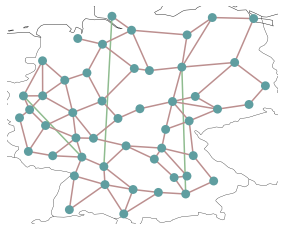

In [12]:
with open(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\objective\elec_s300_16_ec_lcopt_1H.pickle","rb") as f:
            test_dict = pkl.load(f)
print(test_dict)

nnn = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_50_ec_lcopt_1H.nc")
nnn.plot()

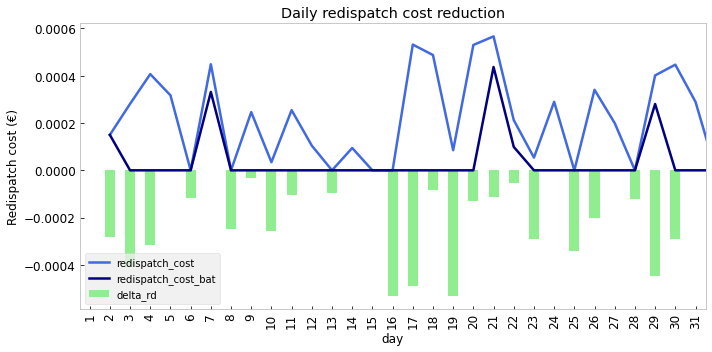

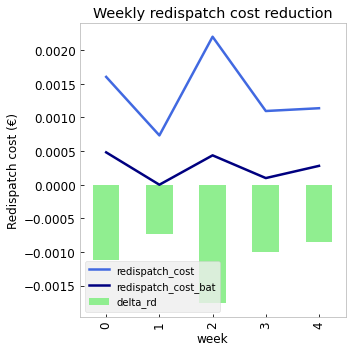

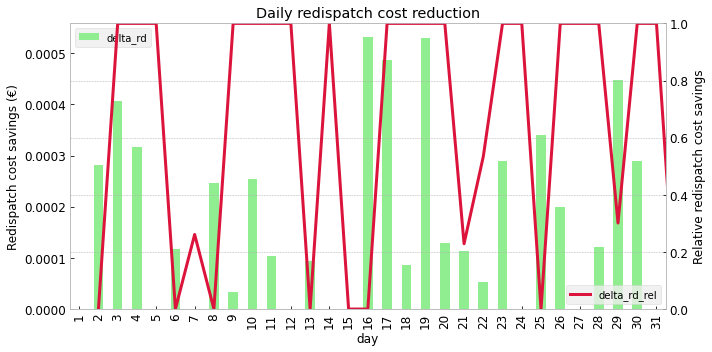

In [37]:
# Plot objective insights
# --------------
colors = ["royalblue","navy","lightgreen"]

# Redispatch cost difference per day
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax  = plt.subplots(figsize = (10, 5))
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
ax = df_obj_day[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_day["delta_rd"].plot.bar(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.5, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Redispatch cost difference per week
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax1  = plt.subplots(figsize = (5, 5))
ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax1.set_xlabel("Time horizon (week)", fontsize = 12)
ax1 = df_obj_week[cols].plot.line(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_week["delta_rd"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.5, fontsize = 12)
ax1.set_facecolor('white')
ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
ax1.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Relative redispatch cost savings vs absolute savings
fig, ax2  = plt.subplots(figsize = (10, 5))
ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
ax2.set_xlabel("Time horizon (day)", fontsize = 12)
ax2 = df_obj_day["delta_rd"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
                                   color = ["lightgreen"], legend = True, fontsize = 12)
ax2.set_facecolor('white')
ax2.legend(loc = "upper left")
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)

# TODO: REMOVE GRAPH OFFSET

ax2_ = ax2.twinx()
df_obj_day["delta_rd_rel"].abs().plot.line(ax = ax2_, linewidth = 3, 
                                           color = "crimson", legend = True, fontsize = 12)
ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
ax2_.set_ylim(0,1.0)
fig.tight_layout()
plt.show()

In [35]:
# ---------------
# Extract results from dispatch & redispatch optimization
#
# Analysis:

# - reduction of line overloading (time with line cap. at 100%)
# - change in merit order dispatch -> redispatch: merit order plotten dispatch vs. redispatch mit und ohne batterien (an beispielhaften
#   tagen mit besonders hoher, mittlerer, und geringer last)
#
# Retionalization of analysis
# - reduction of ramp up/down at specific locations (locations = groups of buses (by their name/number) especially in the north as well as the south)
# - most overloaded lines (lines at 100% capacity), buses with most redispatch energy

# prepare redispatch workflow output for analysis
#def analyze_redispatch_generators(filename):

import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"
filename = "elec_s300_16_ec_lcopt_1H"
network_d = pypsa.Network(import_path + r"\dispatch\\" + filename + r".nc")
network_rd = pypsa.Network(import_path + r"\redispatch\\" + filename + r".nc")
network_rd_bat = pypsa.Network(import_path + r"\dispatch\\" + filename + r"_bat.nc")

print(network_d.objective)
print(network_rd.objective)
print(network_rd_bat.objective)


# Reduction of redispatch energy (positive and negative)
# -----------------------

# Redispatch power dataframe
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
df_rd_p = network_rd.generators_t.p[cols_rd]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]
# sum of positive redispatch
cols_pos = [column for column in list(df_rd_p) if "pos" in column]
df_rd_p["Positive redispatch"] = df_rd_p.loc[:,cols_pos].sum(axis = 1)
df_rd_p_bat["Positive redispatch"] = df_rd_p_bat.loc[:,cols_pos].sum(axis = 1)
# sum of negative redispatch
cols_neg = [column for column in list(df_rd_p) if "neg" in column]
df_rd_p["Negative redispatch"] = df_rd_p.loc[:,cols_neg].sum(axis = 1)
df_rd_p_bat["Negative redispatch"] = df_rd_p_bat.loc[:,cols_neg].sum(axis = 1)


# Difference of redispatch (pos/neg) and total redispatch datarame
df_bat_nobat = pd.concat([df_rd_p[["Negative redispatch", "Positive redispatch"]], 
                             df_rd_p_bat[["Negative redispatch", "Positive redispatch"]]], 
                            axis = 1)
df_bat_nobat.columns = ["Negative redispatch", "Positive redispatch",
                       "Negative redispatch bat", "Positive redispatch bat"]
# differences in redispatch bat vs no bat
df_bat_nobat["Difference in curtailment"] = df_bat_nobat.iloc[:,2] - df_bat_nobat.iloc[:,0]
df_bat_nobat["Difference in ramp-up"] = df_bat_nobat.iloc[:,3] - df_bat_nobat.iloc[:,1]
df_bat_nobat["Total redispatch"] = abs(df_bat_nobat.loc[:,["Negative redispatch", 
                                                           "Positive redispatch"]]).sum(axis = 1)
df_bat_nobat["Total redispatch bat"] = abs(df_bat_nobat.loc[:,["Negative redispatch bat", 
                                                "Positive redispatch bat"]]).sum(axis = 1)
df_bat_nobat["Total redispatch difference"] = df_bat_nobat["Total redispatch bat"] - df_bat_nobat["Total redispatch"]
display(df_bat_nobat)



        

# # Dispatch time series
# df_dispatch_t = network.generators_t.p.copy()
# df_dispatch_t["Sum"] = df_dispatch_t.sum(axis = 1)





C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_16_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set op

9278485558.409996
11633976.385832135
2195.5586247327174


,Negative redispatch,Positive redispatch,Negative redispatch bat,Positive redispatch bat,Difference in curtailment,Difference in ramp-up,Total redispatch,Total redispatch bat,Total redispatch difference
name,,,,,,,,,
2018-01-01 00:00:00,0.0,0.000093,0.0,0.0,0.0,-0.000093,0.000093,0.0,-0.000093
2018-01-01 01:00:00,0.0,0.000093,0.0,0.0,0.0,-0.000093,0.000093,0.0,-0.000093
2018-01-01 02:00:00,0.0,0.000093,0.0,0.0,0.0,-0.000093,0.000093,0.0,-0.000093
2018-01-01 03:00:00,0.0,0.000093,0.0,0.0,0.0,-0.000093,0.000093,0.0,-0.000093
2018-01-01 04:00:00,0.0,0.000093,0.0,0.0,0.0,-0.000093,0.000093,0.0,-0.000093
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.0,0.000120,NaN,NaN,NaN,NaN,0.000120,0.0,-0.000120
2018-12-31 20:00:00,0.0,0.000138,NaN,NaN,NaN,NaN,0.000138,0.0,-0.000138
2018-12-31 21:00:00,0.0,0.000122,NaN,NaN,NaN,NaN,0.000122,0.0,-0.000122


In [33]:
# Extract results from dispatch & redispatch optimization



# cost reduction
delta_objective = network_rd.objective - network_rd_bat.objective
print(round(delta_objective, 2))

# Dispatch time series
df_dispatch_t = network.generators_t.p.copy()
df_dispatch_t["Sum"] = df_dispatch_t.sum(axis = 1)

# Redispatch w/o batteries
# ------------------------

# Redispatch df
df_redispatch_t = network_rd.generators_t.p.copy()
cols_rd = [column for column in list(df_redispatch_t) if "pos" in column or "neg" in column]         
df_redispatch_t = df_redispatch_t.copy()[cols_rd]

# Resulting dispatch after redispatch
#display(df_redispatch_t)

# Absolute redispatch df
df_redispatch_abs = df_redispatch_t.abs()
df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# df for positive rd
cols_rd_pos = [column for column in list(df_redispatch_t) if "pos" in column]         
df_redispatch_t_pos = df_redispatch_t.copy()[cols_rd_pos]
df_redispatch_t_pos["Sum pos"] = df_redispatch_t_pos.sum(axis = 1)

# df for negative rd
cols_rd_neg = [column for column in list(df_redispatch_t) if "neg" in column]         
df_redispatch_t_neg = df_redispatch_t.copy()[cols_rd_neg]
df_redispatch_t_neg["Sum neg"] = df_redispatch_t_neg.sum(axis = 1)

# Add sums to redispatch df
df_redispatch_t["Sum pos"] = df_redispatch_t_pos["Sum pos"]
df_redispatch_t["Sum neg"] = df_redispatch_t_neg["Sum neg"]


# Redispatch w/ batteries
# ------------------------

# Redispatch time series with batteries
df_redispatch_t_bat = network_rd_bat.generators_t.p.copy()
cols_rd = [column for column in list(df_redispatch_t_bat) if "pos" in column or "neg" in column]         
df_redispatch_t_bat = df_redispatch_t_bat[cols_rd].copy()

# Absolute redispatch df
df_redispatch_abs = df_redispatch_t_bat.abs()
df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# df for positive rd
cols_rd_pos = [column for column in list(df_redispatch_t_bat) if "pos" in column]         
df_redispatch_t_bat_pos = df_redispatch_t_bat.copy()[cols_rd_pos]
df_redispatch_t_bat_pos["Sum pos"] = df_redispatch_t_bat_pos.sum(axis = 1)

# df for negative rd
cols_rd_neg = [column for column in list(df_redispatch_t_bat) if "neg" in column]         
df_redispatch_t_bat_neg = df_redispatch_t_bat.copy()[cols_rd_neg]
df_redispatch_t_bat_neg["Sum neg"] = df_redispatch_t_bat_neg.sum(axis = 1)

# Add sums to redispatch df
df_redispatch_t_bat["Sum pos"] = df_redispatch_t_bat_pos["Sum pos"]
df_redispatch_t_bat["Sum neg"] = df_redispatch_t_bat_neg["Sum neg"]

# df with difference of redispatch
df_bat_vs_nobat = pd.concat([df_redispatch_t[["Sum pos", "Sum neg"]], df_redispatch_t_bat[["Sum pos", "Sum neg"]]], axis = 1)
df_bat_vs_nobat["Difference positive"] = abs(df_bat_vs_nobat.iloc[:,0] - df_bat_vs_nobat.iloc[:,2])
df_bat_vs_nobat["Difference negative"] = - abs(df_bat_vs_nobat.iloc[:,1] - df_bat_vs_nobat.iloc[:,3])
#display(df_bat_vs_nobat)

# battery charging operations (of one in the north and one in the south)
df_bess = network_rd_bat.stores
df_bess_t_p = network_rd_bat.stores_t.p

display(network_rd_bat.stores_t.p)
display(network_rd_bat.stores_t.e)
display(network_rd_bat.stores.e_nom.T)
df_bess_SOC = network_rd_bat.stores_t.e / network_rd_bat.stores.e_nom.T
print("df_bess_SOC")
display(df_bess_SOC)






C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

INFO:pypsa.io:Imported network elec_s300_16_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:769: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

C:\Users\Willem\.conda\envs\pypsa-eur\lib\site-packages\pypsa\io.py:771: FutureWarning:

Index.__or__ operating as a set op

9278485558.409996
11633976.385832135
2195.5586247327174
11631780.83


NameError: name 'network' is not defined

In [ ]:
# ------------------------
# Plots w/o bat
# ------------------------

# # Dispatch time series
# cols = list(df_dispatch_t)[:-1]
# fig, ax  = plt.subplots(figsize = (10, 5))
# ax.set_ylabel('MW Redispatch',  fontsize = 12)
# ax = df_dispatch_t.loc[:, cols].plot.bar(stacked = True, ax = ax, title = "Dispatch after market clearing", legend = True, fontsize = 12)
# ax.set_facecolor('white')
# ax.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (pos vs. neg aggregate) 
# cols_0 = list(df_redispatch_t)[-2:]
# fig, ax_0  = plt.subplots(figsize = (10, 5))
# ax_0.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_0 = df_redispatch_t.loc[:, cols_0].plot.bar(stacked = True, ax = ax_0, title = "Amount of redispatch", legend = True, fontsize = 12)
# ax_0.set_facecolor('white')
# ax_0.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (aggregate) 
# cols_1 = list(df_redispatch_abs)[:-1]
# fig, ax_1  = plt.subplots(figsize = (10, 5))
# ax_1.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_1 = df_redispatch_abs.loc[:, cols_1].plot.bar(stacked = True, ax = ax_1, title = "Aggregated amount of redispatch", legend = True, fontsize = 12)
# ax_1.set_facecolor('white')
# ax_1.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (positive rd) 
# cols_2 = list(df_redispatch_t_pos)[:-1]
# fig, ax_2  = plt.subplots(figsize = (10, 5))
# ax_2.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_2 = df_redispatch_t_pos.loc[:, cols_2].plot.bar(stacked = True, ax = ax_2, title = "Amount of positive redispatch (ramp up)", legend = True, fontsize = 12)
# ax_2.set_facecolor('white')
# ax_2.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (negative rd) 
# cols_3 = list(df_redispatch_t_neg)[:-1]
# fig, ax_3  = plt.subplots(figsize = (10, 5))
# ax_3.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_3 = df_redispatch_t_neg.loc[:, cols_3].plot.bar(stacked = True, ax = ax_3, title = "Amount of negative redispatch (curtailment)", legend = True, fontsize = 12)
# ax_3.set_facecolor('white')
# ax_3.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Plots w/ bat
# # ------------------------

# Redispatch time series (pos vs. neg aggregate) 
cols_4 = list(df_redispatch_t_bat)[-2:]
fig, ax_4  = plt.subplots(figsize = (10, 5))
ax_4.set_ylabel('MW Redispatch',  fontsize = 12)
ax_4 = df_redispatch_t_bat.loc[:, cols_4].plot.bar(stacked = True, ax = ax_4, title = "Amount of positive and negative redispatch", legend = True, fontsize = 12)
ax_4.set_facecolor('white')
ax_4.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Difference positive vs negative redispatch 
cols_5 = list(df_bat_vs_nobat)[-2:]
fig, ax_5  = plt.subplots(figsize = (10, 5))
ax_5.set_ylabel('MW Redispatch',  fontsize = 12)
ax_5 = df_bat_vs_nobat.loc[:, cols_5].plot.bar(stacked = True, ax = ax_5, title = "Difference between redispatch with and without bat", legend = True, fontsize = 12)
ax_5.set_facecolor('white')
ax_5.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Plots battery insights
# ------------------------

# Battery charging operations (battery in the north)
cols_6 = ["BESS_1","BESS_2","BESS_3"]
fig, ax_6  = plt.subplots(figsize = (10, 5))
ax_6.set_ylabel('MW Redispatch',  fontsize = 12)
ax_6 = df_bess_t_p.loc[:, cols_6].plot.bar(stacked = True, ax = ax_6, title = "Battery active power in redispatch", legend = True, fontsize = 12)
ax_6.set_facecolor('white')
ax_6.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Battery SOC
cols_7 = ["BESS_1","BESS_2","BESS_3"]
fig, ax_7  = plt.subplots(figsize = (10, 5))
ax_7.set_ylabel('Battery SOC',  fontsize = 12)
ax_7 = df_bess_SOC.loc[:, cols_7].plot.line(stacked = False, ax = ax_7, title = "Battery SOC during redispatch", legend = True, fontsize = 12)
ax_7.set_facecolor('white')
ax_7.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)
                   

        
    
